In [1]:
# 載入相關套件
import numpy as np
import random

In [2]:
# 參數設定
NODE_COUNT = 15        # 節點數
NORMAL_REWARD = -0.02  # 每走一步扣分0.02

In [3]:
# 環境類別
class Environment():

    # 初始化
    def __init__(self):

        # 儲存狀態值函數(State Value Function)
        # 索引值[0]不用，從1開始
        self.state_value = np.full((NODE_COUNT + 1), 0.0)

        # 記錄每個狀態被更新的次數
        # 索引值[0]不用，從1開始
        self.state_value_count = np.full((NODE_COUNT + 1), 0)
        
    # 重置遊戲
    def reset(self):
        # 玩家一開始站在中間位置
        self.poistion = int((1 + NODE_COUNT) / 2)
        # 記錄玩家行動軌跡
        self.trajectory = [self.poistion]

    # 取得所有可能的狀態
    def get_states(self):
        # 狀態空間(State Space) = 1到NODE_COUNT
        return [i for i in range(1, NODE_COUNT+1)]

    # 取得行動空間
    def get_actions(self):  
        # 行動空間(Action Space) = 向左(-1)或向右(+1)
        return [-1, 1]

    # 判斷遊戲是否結束
    def is_done(self):
        # 若玩家到達左右端點，回合結束
        return self.poistion == 1 or self.poistion == NODE_COUNT
    
    # 執行一步動作
    def step(self, action):
        # 如果遊戲已結束，不能再走
        if self.is_done():
            raise Exception("Game over")

        # 更新玩家位置
        self.poistion += action

        # 紀錄行動軌跡
        self.trajectory.append(self.poistion)        
        
        # 判斷獎勵
        if self.poistion == 1:
            reward = -1             # 到達左端負獎勵
        elif self.poistion == NODE_COUNT:
            reward = 1              # 到達右端正獎勵
        else:    
            reward = NORMAL_REWARD  # 中間位置一般獎勵
        return self.poistion, reward

    # 更新狀態值函數
    def update_state_value(self, final_value):
        # 倒推更新，每個走過的節點加上最終獎勵
        # 缺點：同一節點走過多次，分數可能被重複計算

        for i in range(len(self.trajectory)-1, -1, -1):
            final_value += NORMAL_REWARD
            self.state_value[self.trajectory[i]] += final_value
            self.state_value_count[self.trajectory[i]] += 1
                
    # 取得狀態值函數的期望值
    def get_observation(self):
        mean1 = np.full((NODE_COUNT + 1), 0.0)
        for i in range(1, NODE_COUNT + 1):
            if self.state_value_count[i] == 0: 
                mean1[i] = 0  # 若未更新過，期望值為0
            else:
                # 狀態值函數平均值 = 總分 / 更新次數
                mean1[i] = self.state_value[i] / self.state_value_count[i]
        return mean1

In [4]:
# 代理人類別(Agent)
class Agent():

    # 初始化
    def __init__(self):
        # 目前不需要額外變數
        pass
        
    # 根據環境選擇行動
    def action(self, env):
        # 取得當前環境的狀態值函數期望值(各節點的估計價值)
        state_value = env.get_observation()
        
        # 以左/右節點的狀態值函數大小來決定行動。如果左邊的價值比右邊大，則向左走
        if state_value[env.poistion - 1] > state_value[env.poistion + 1]: 
            next_action = -1

        # 如果右邊的價值比左邊大，則向右走
        if state_value[env.poistion - 1] < state_value[env.poistion + 1]: 
            next_action = 1

        # 如果左右節點的價值相等，則隨機選擇向左或向右
        else:  
            next_action = random.choice(env.get_actions())
        
        # 回傳選擇的行動
        return next_action

In [5]:
# 建立實驗，初始化環境(Environment)與代理人(Agent)物件
env = Environment()
agent = Agent()

# 儲存每次實驗的累計報酬
total_reward_list = []

# 執行10次實驗
for i in range(10):
    env.reset()       # 重置環境(將玩家位置回到中間，清空軌跡)
    total_reward = 0  # 初始化累計報酬
    action_count = 0  # 計算該回合採取的行動次數

    # 當遊戲未結束時持續進行
    while not env.is_done():
        # 代理人選擇行動(根據狀態值函數)
        action = agent.action(env)
        action_count += 1
        
        # 更新環境，取得新的狀態與該步獎勵
        state, reward = env.step(action)

        # 將獎勵累加到總報酬
        total_reward += reward
        
        # 防止無限循環，若行動次數超過100，強制結束並重置位置
        if action_count > 100:
            env.poistion = int((1 + NODE_COUNT) / 2)
            break
    
    # 顯示該回合的行動軌跡
    print(f'trajectory {i}: {env.trajectory}')
    
    # 只有在未超過100步才更新狀態值函數，以免過度降低循環節點的價值
    if action_count <= 100:
        env.update_state_value(total_reward)

    # 將該回合的累計報酬加入列表
    total_reward_list.append(round(total_reward, 2))
    
# 顯示所有回合的累計報酬
print(f"累計報酬: {total_reward_list}")

trajectory 0: [8, 7, 6, 5, 4, 3, 2, 1]
trajectory 1: [8, 9, 10, 9, 10, 11, 12, 11, 10, 11, 12, 13, 14, 13, 14, 13, 12, 13, 14, 15]
trajectory 2: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 3: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 4: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 5: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 6: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 7: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 8: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 9: [8, 9, 10, 11, 12, 13, 14, 15]
累計報酬: [-1.12, 0.64, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]


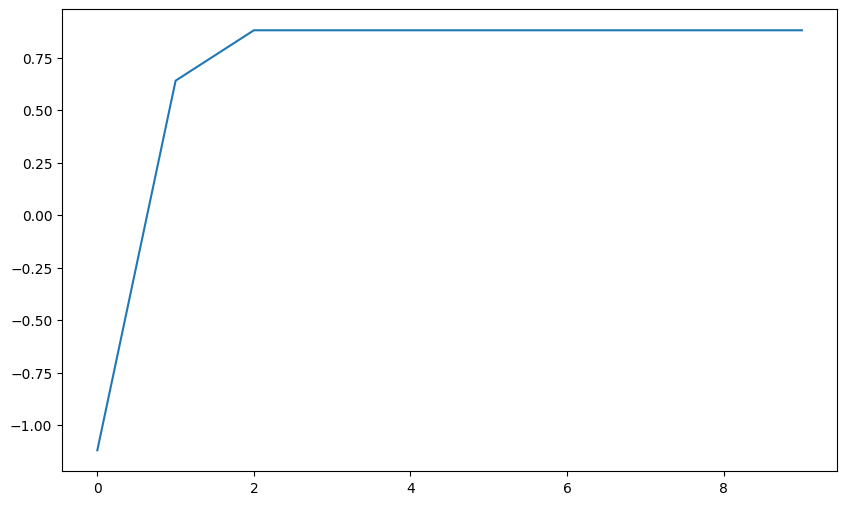

In [6]:
# 匯入繪圖套件matplotlib
import matplotlib.pyplot as plt

# 建立一個畫布，設定大小為10x6吋
plt.figure(figsize=(10,6))

# 繪製累計報酬(total_reward_list)隨回合變化的折線圖
plt.plot(total_reward_list)

In [7]:
# 取得環境中所有節點的狀態值期望(排除索引0，因為索引0沒有使用)
env.get_observation()[1:]

array([-1.14      , -1.16      , -1.18      , -1.2       , -1.22      ,
       -1.24      , -1.26      ,  0.472     ,  0.648     ,  0.64363636,
        0.67090909,  0.70545455,  0.72      ,  0.75636364,  0.83333333])